In [13]:
import torch
import matplotlib.pyplot as plt
import numpy
import sys
from torch.utils.data import Dataset, DataLoader
sys.path.insert(0, "..")
from classes.nn_classes import NNmodel

In [14]:
class Diffeq_model(NNmodel):
    def __init__(self, input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__(input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias)
    
    def forward(self, x):
        result = super().forward(x)
        return result, torch.autograd.grad(result, x, torch.ones_like(result), create_graph=True)[0]

class MyCostumDataset(Dataset):
    def __init__(self, xs, ys, ys_deriv) -> None:
        super().__init__()
        self.xs = xs
        self.ys = ys
        self.ys_deriv = ys_deriv

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, index):
        return self.xs[index], self.ys[index], self.ys_deriv[index]

In [15]:
def dyds(s, a=36.78558520):
    return s/torch.sqrt(a**2 + s**2)

def dxds(s, a=36.78558520):
    return a/torch.sqrt(a**2 + s**2)

def train_diff_model(diff_eq, model, train_loader, optimizer, 
                     epochs=500,
                     loss_func=torch.nn.MSELoss(), 
                     N_randoms=500,
                     x_max = 10.0,
                     x_min = 0.0,
                     gamma = 1.0,
                     ):
    train_losses = torch.zeros(epochs, 1)
    for epoch in range(epochs):
        model.train()
        for x_dat, y_dat, y_deriv in train_loader:
            x_for_deriv = (torch.rand(N_randoms)*(x_max - x_min) + x_min).view(-1,1)
            x_for_deriv.requires_grad = True
            optimizer.zero_grad()
            prediction_y, y_deriv_pred = model.forward(x_dat)
            loss = loss_func(prediction_y, y_dat) + gamma*loss_func(y_deriv_pred, y_deriv)
            train_losses[epoch] += loss.item()*x_dat.size(0) 
            _, deriv_pred = model.forward(x_for_deriv)
            loss_deriv = gamma*loss_func(deriv_pred, diff_eq(x_for_deriv))
            loss+=loss_deriv
            train_losses[epoch] += loss_deriv.item() 
            loss.backward()
            optimizer.step()
    return train_losses

In [17]:
s_init = torch.tensor([0.0], requires_grad=True)

y_init = torch.tensor([0.0], requires_grad=True)
x_init = torch.tensor([0.0], requires_grad=True)

y_deriv = torch.tensor([0.0], requires_grad=True)
x_deriv = torch.tensor([1.0], requires_grad=True)

x_train_set = MyCostumDataset(xs=s_init, ys=x_init, ys_deriv=x_deriv)
y_train_set = MyCostumDataset(xs=s_init, ys=y_init, ys_deriv=y_deriv)

x_train_loader = DataLoader(x_train_set, batch_size=1)
y_train_loader = DataLoader(y_train_set, batch_size=1)


In [50]:
dim_hiddens = [(2,2), (2,4), (2,10)]
dxds_models = [Diffeq_model(input_dim=1, output_dim=1, num_hidden_layers=dim_hidden[0], dim_hiddens=dim_hidden[1], activation_func=torch.nn.SiLU()) for dim_hidden in dim_hiddens]
dyds_models = [Diffeq_model(input_dim=1, output_dim=1, num_hidden_layers=dim_hidden[0], dim_hiddens=dim_hidden[1], activation_func=torch.nn.SiLU()) for dim_hidden in dim_hiddens]

for dxds_model in dxds_models:
    optimizer = torch.optim.Adam(params=dxds_model.parameters(), lr=1e-3)
    train_diff_model(diff_eq=dxds, model=dxds_model, train_loader=x_train_loader, optimizer=optimizer, epochs=5000, x_max=21, x_min=0, gamma=1.0, N_randoms=32)

for dyds_model in dyds_models:
    optimizer = torch.optim.Adam(params=dyds_model.parameters(), lr=1e-3)
    train_diff_model(diff_eq=dyds, model=dyds_model, train_loader=y_train_loader, optimizer=optimizer, epochs=5000, x_max=21, x_min=0, gamma=1.0, N_randoms=32)

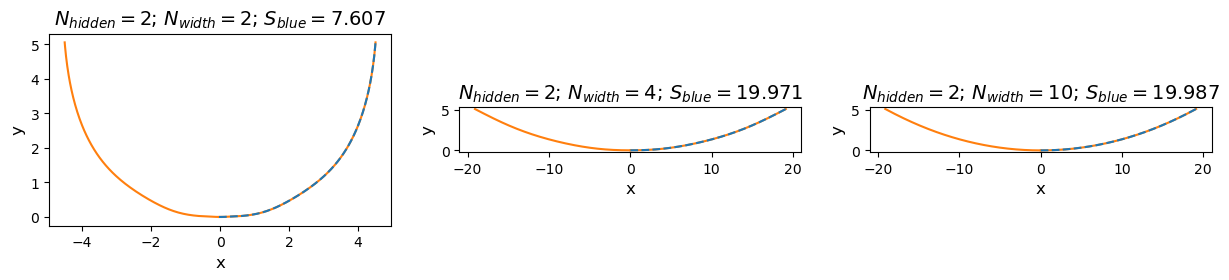

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
s = torch.linspace(0, 20, 200, requires_grad=True).view(-1,1)

for dxds_model, dyds_model, ax, dim_hidden in zip(dxds_models, dyds_models, axs, dim_hiddens):
    xs, _ = dxds_model.forward(s)
    ys, _ = dyds_model.forward(s)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    with torch.no_grad():
        sum = torch.sum(torch.sqrt((xs[0:-1] - xs[1:])**2 + (ys[0:-1] - ys[1:])**2))
        ax.set_title(r"$N_{hidden} = $"+f"{dim_hidden[0]}; " + r"$N_{width} = $" + f"{dim_hidden[1]}; " + r"$S_{blue} = $"+f"{round(sum.item(), 3)}", fontsize=14)
        ax.plot(xs, ys, "C1")
        ax.plot(-xs, ys, "C1")
        ax.plot(xs, ys, ls="--", c="C0")
        ax.set_aspect("equal")